In [1]:
import confmain
import os
import math
import numpy as np
import pandas as pd

import tensorflow as tf

import pywt
import wfdb
from wfdb import processing

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from util_module import util_func
from util_module.ecg_signal import ECGSignal

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
CURR_DIR = os.getcwd()
DATA_DIR = os.path.join(CURR_DIR, '../data/ludb')

**ST-elevation on records [7, 21, 24, 33, 55, 64, 69, 86]**

In [3]:
# def remove_zero_padding(signal, segment, thresh=50):
#     if len(signal) != len(segment):
#         print('Signal and segment length mismatch!')
#         return

#     counter = 0
#     ptr_start_zero_pad = 0

#     for i in reversed(range(len(signal))):
#         if (signal[i] != 0) and (segment[i] != 7):
#             counter += 1
#             if (signal[i+1] == 0) and (segment[i+1] == 7):
#                 ptr_start_zero_pad = i + 1
        
#         if (signal[i] == 0) and (segment[i] == 7):
#             counter = 0
        
#         if counter == thresh:
#             break
    
#     signal = signal[:ptr_start_zero_pad]
#     segment = segment[:ptr_start_zero_pad]

#     return signal, segment

In [4]:
INPUT_LENGTH = 816

FS = 500
T1 = 125
T2 = 245

MIN_BPM = 20
MAX_BPM = 230

SEARCH_RADIUS = int(FS * 60 / MAX_BPM)

WAVELET_FUNCTION = 'bior3.3'
DECOMPOSITION_LEVEL = 7

# STEMI_RECORD = [7, 21, 24, 33, 55, 64, 69, 86]
# LEADS = ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
STEMI_RECORD = [7]
LEADS = ['ii']

INTERPRETATION_TO_NUM = {
    'Neither': 0,
    'ST-elevation': 1,
    'ST-depression': 2
}

In [5]:
# DEPRECATED

# def get_amp_diff(lead, sex, age):
#     amp_diff = 0.1
#     if lead == 'v2' or lead == 'v3':
#         if sex == 'M':
#             if age >= 40:
#                 amp_diff = 0.2
#             elif age < 40:
#                 amp_diff = 0.25
        
#         elif sex == 'F':
#             amp_diff = 0.15
    
#     else:
#         amp_diff = 0.1
    
#     return amp_diff

def moving_average(signal, window_size=50): # default 1/10 sampling frequency
    kernel = np.ones(window_size) / window_size

    return np.convolve(signal, kernel, mode='valid')

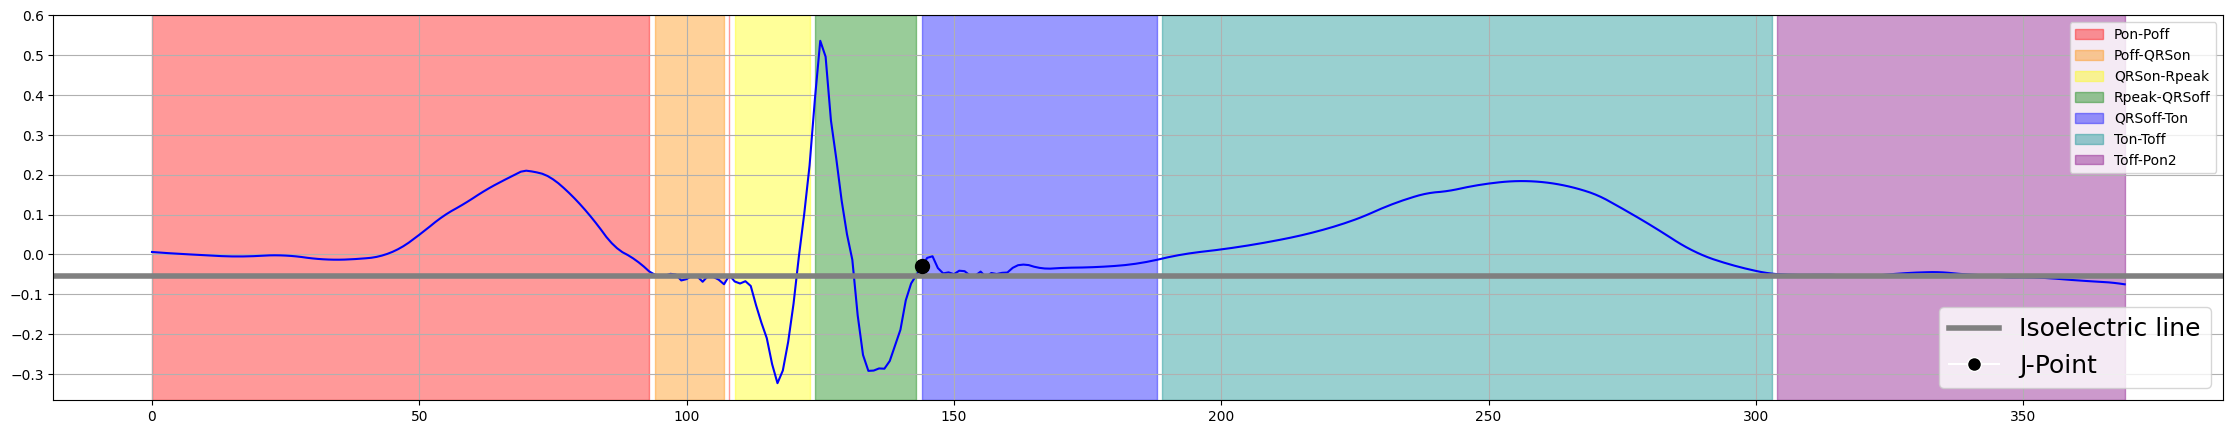

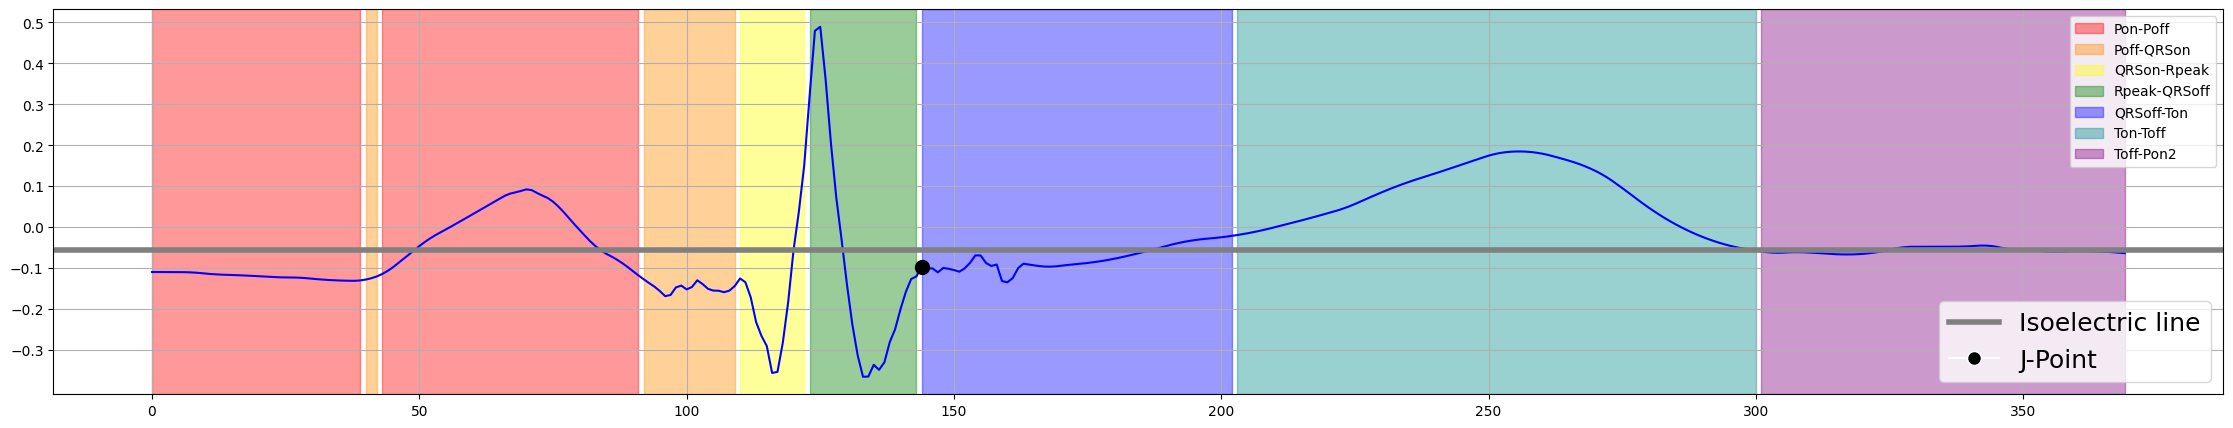

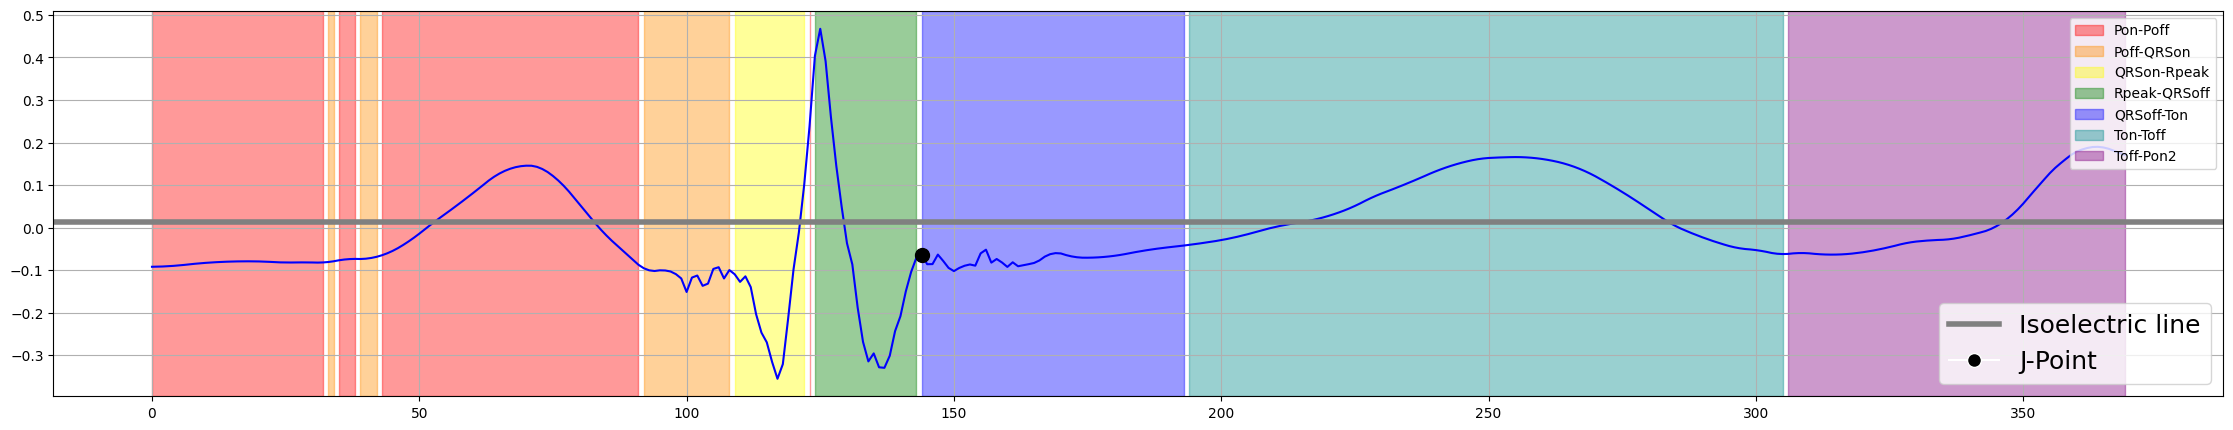

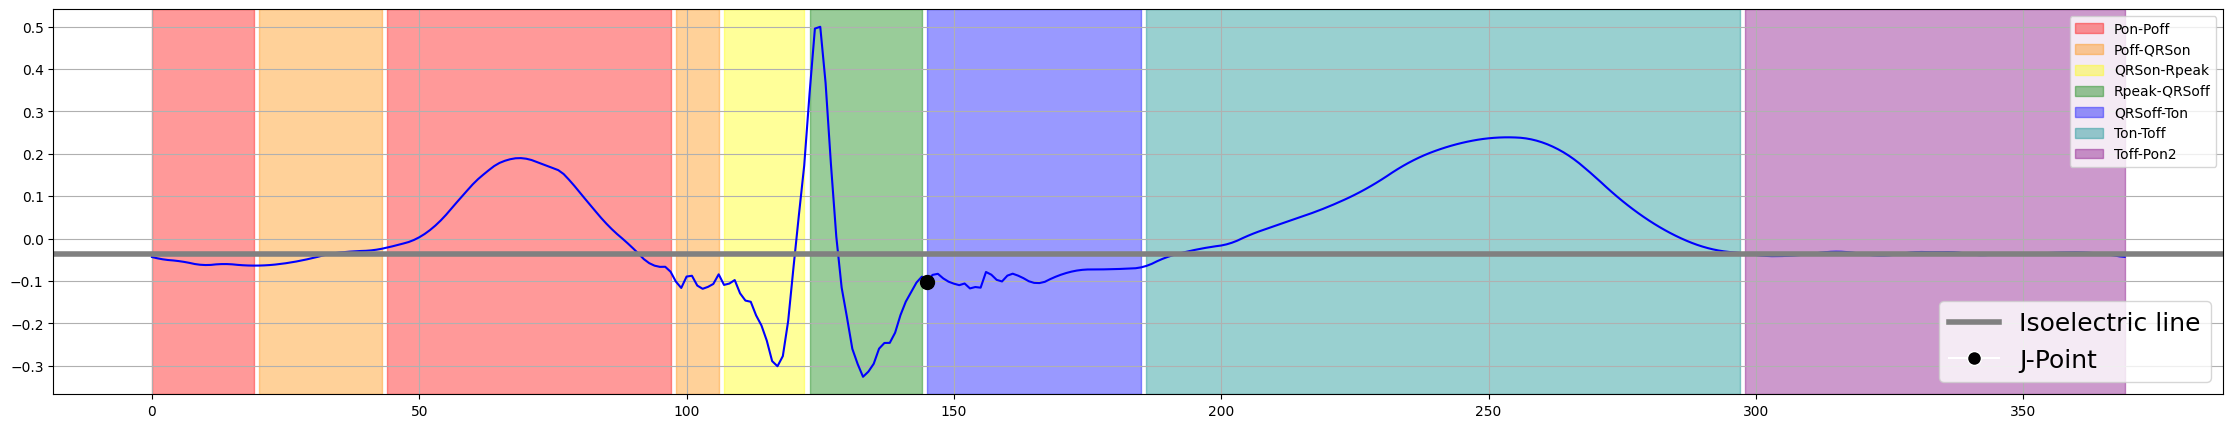

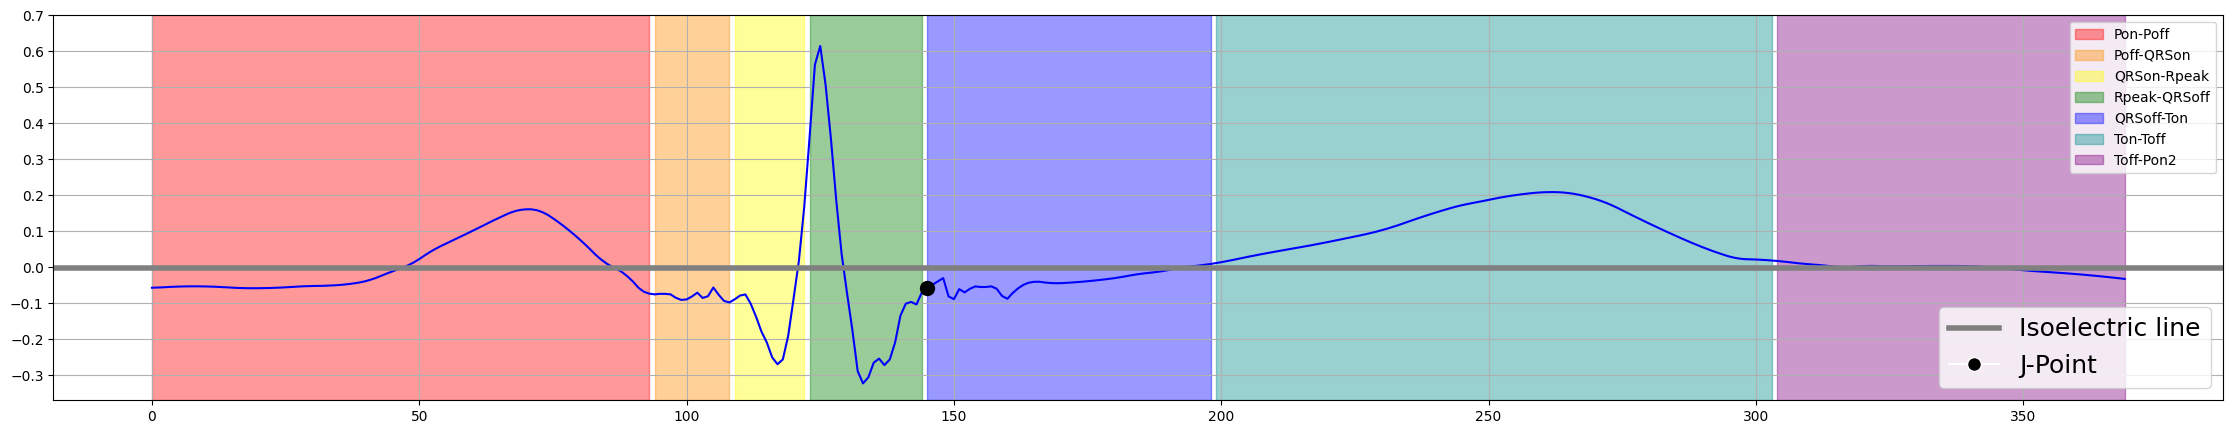

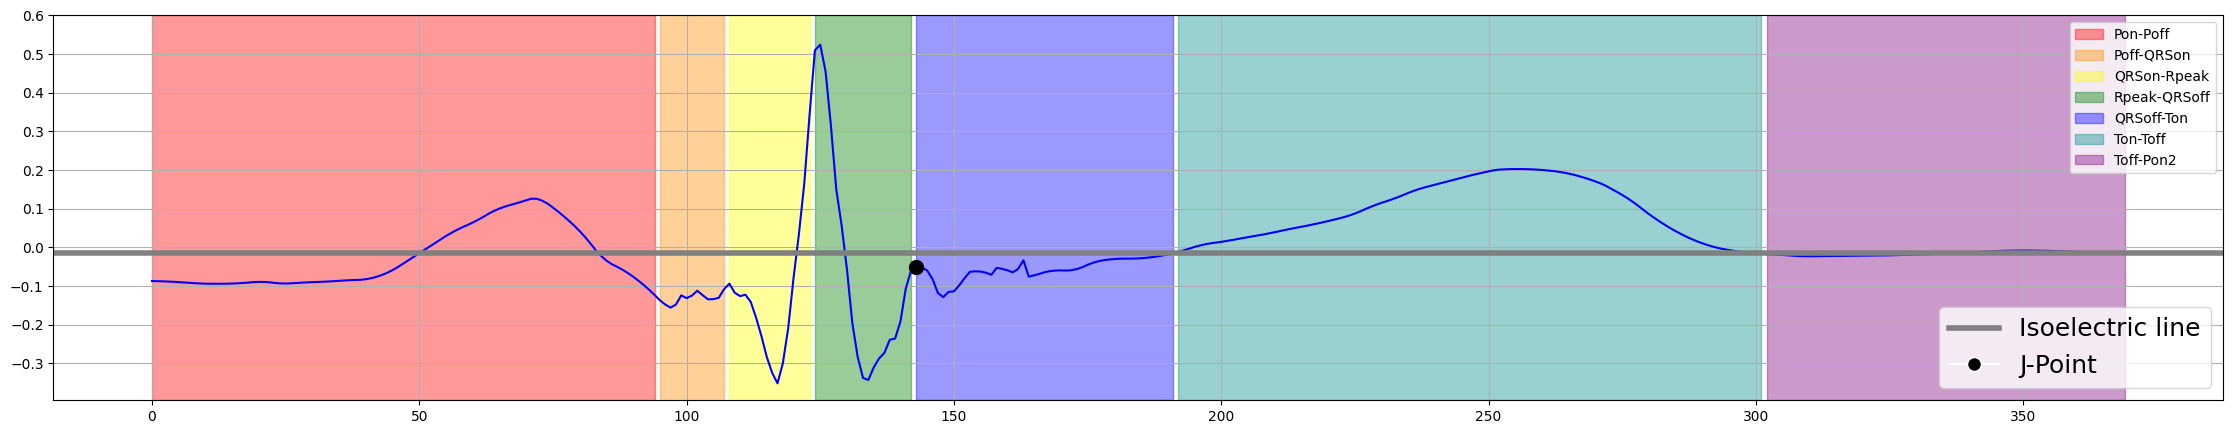

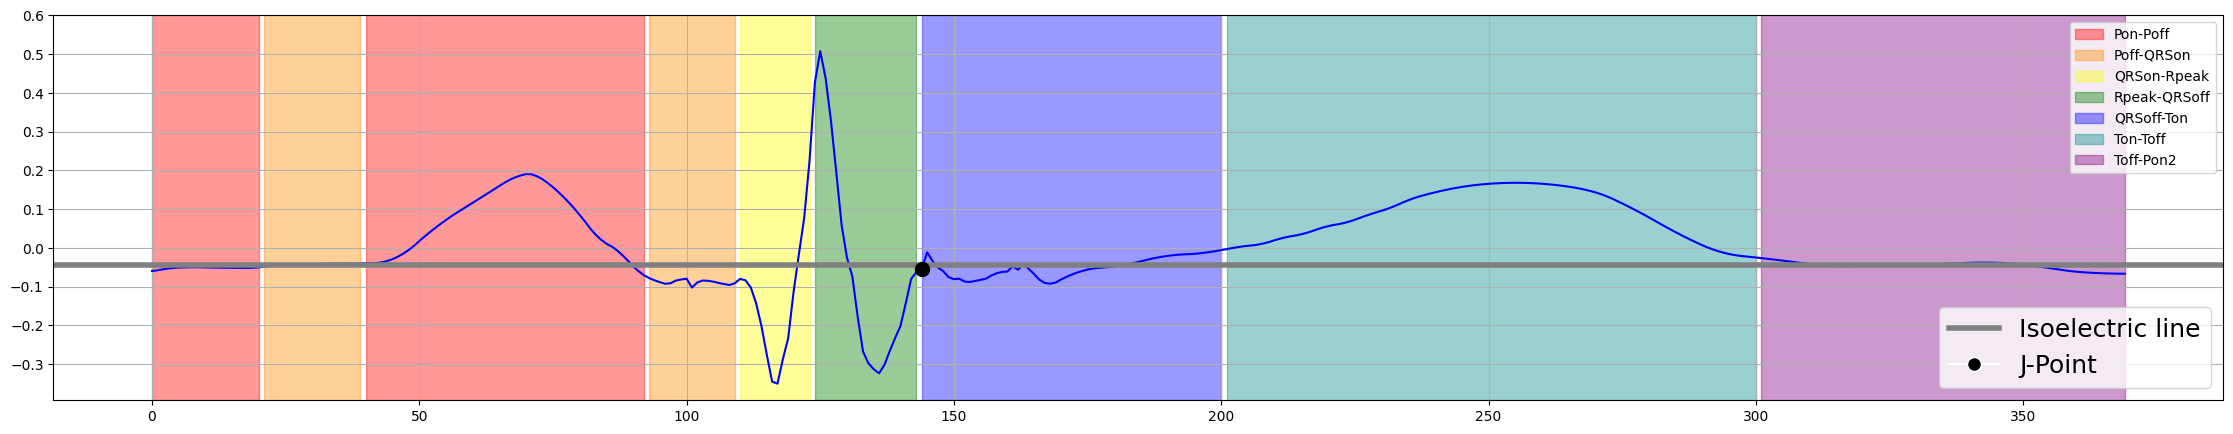

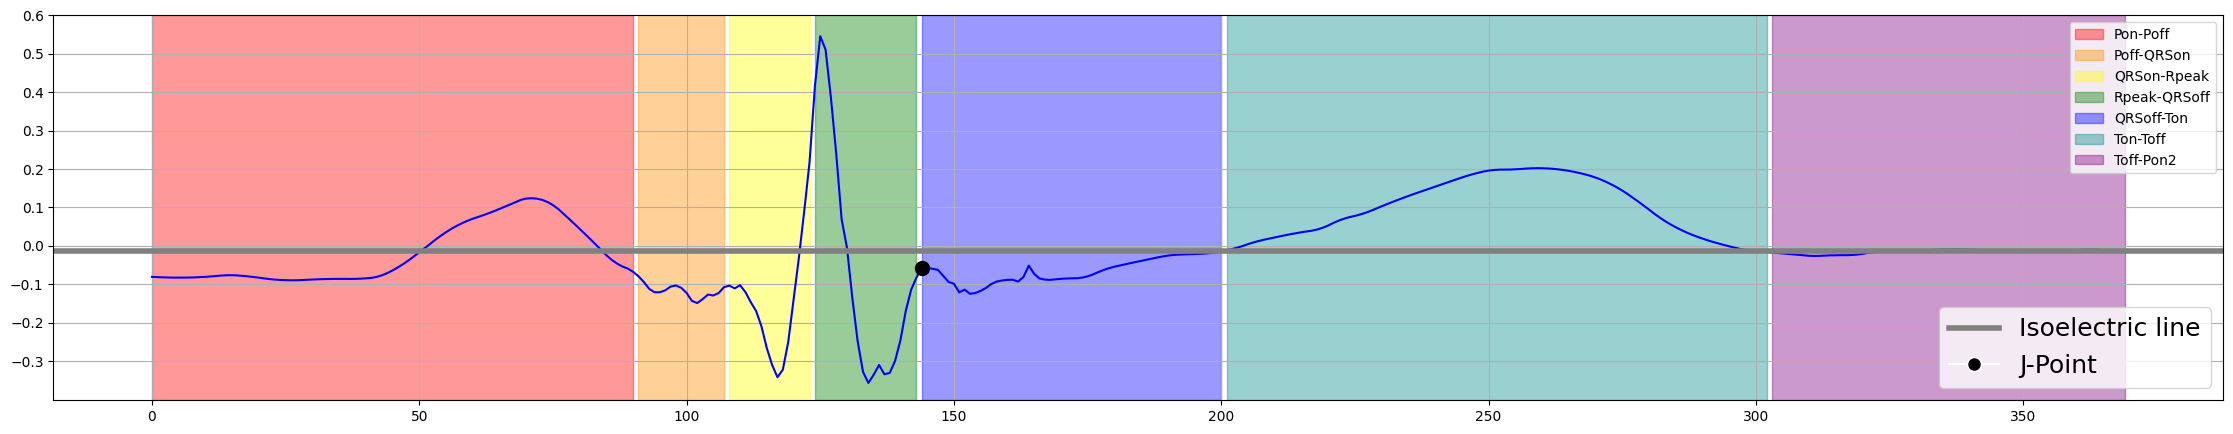

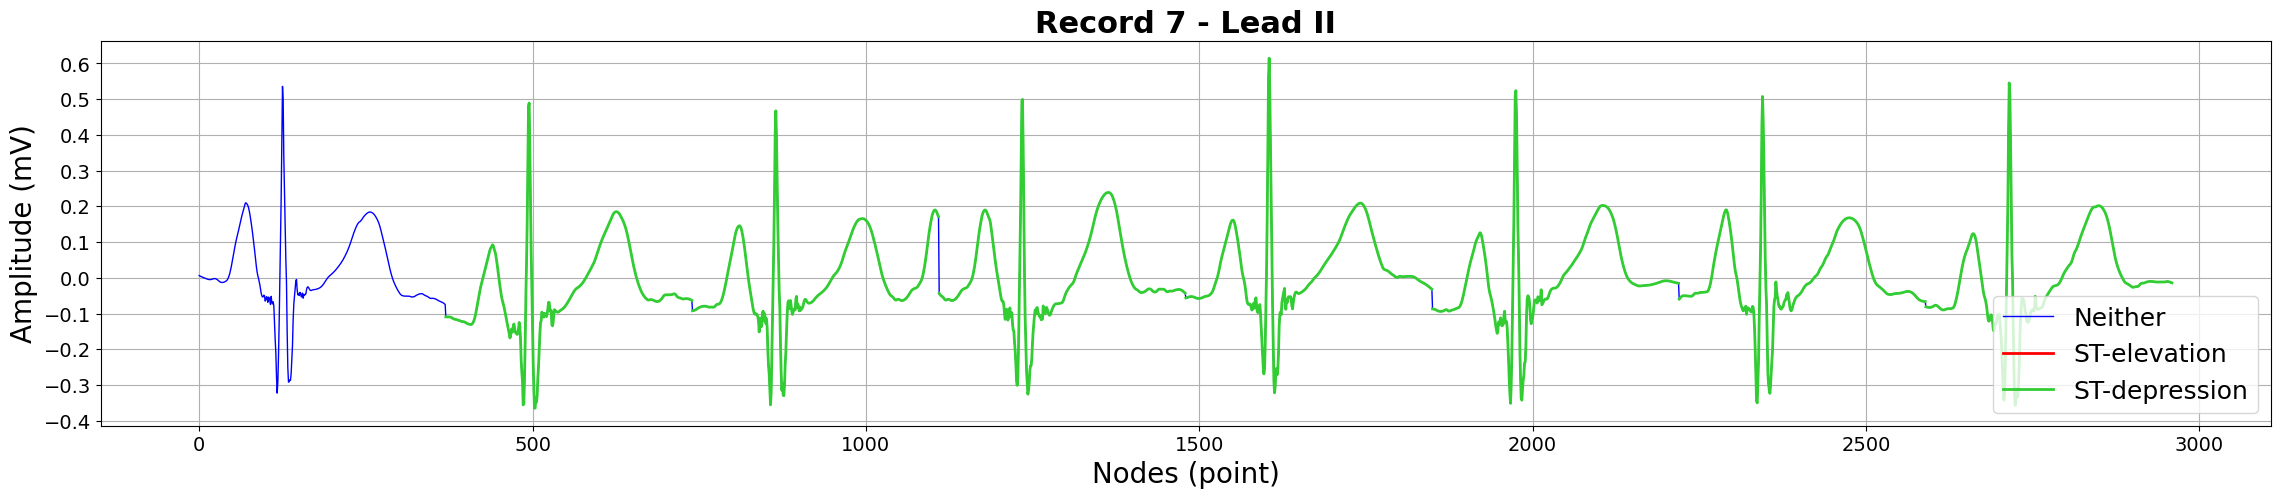

In [6]:
for lead in LEADS:
    data = ECGSignal.get_signal(leads=[lead])

    model = tf.keras.models.load_model(f'../model/{lead}-CustomModel.h5')
    
    stemi_data = zip(
        [data['record_number'][i-1] for i in STEMI_RECORD],
        [data['signal'][i-1] for i in STEMI_RECORD],
    )

    for record_num, signal in stemi_data:
        signal = util_func.denoise_dwt(signal, wavelet=WAVELET_FUNCTION, level=DECOMPOSITION_LEVEL)
        raw_signal = signal
        signal = processing.normalize_bound(signal)

        index_qrs = processing.gqrs_detect(signal, fs=FS)

        if len(index_qrs) == 0:
            print("Can't detect QRS")
            continue

        corrected_peak_inds = processing.peaks.correct_peaks(
            signal,
            peak_inds=index_qrs,
            search_radius=SEARCH_RADIUS,
            smooth_window_size=150,
        )

        if len(corrected_peak_inds) % 2 != 0:
            corrected_peak_inds = np.delete(corrected_peak_inds, -1)

        offset = 0
        beats = []
        raw_beats = []
        delineations = []

        beat_interpretations = []

        for j, peak in enumerate(corrected_peak_inds):
            if (peak - T1) < 0 or (peak + T2) > len(signal):
                continue
            
            raw_beat = raw_signal[peak - T1 : peak + T2]
            beat = signal[peak - T1 : peak + T2]

            beat = np.pad(beat, (0, INPUT_LENGTH - len(beat)))
            beat = beat.reshape((1, -1, 1))

            y_pred = model.predict(beat, verbose=0)
            y_pred = y_pred.round().reshape((INPUT_LENGTH, 8))
            y_pred = y_pred.argmax(axis=1)

            segment_start_end = util_func.get_segment_start_end(y_pred)

            beat = beat.flatten()

            beat, y_pred = util_func.remove_zero_padding(beat, y_pred)
            
            beats.extend(beat)
            raw_beats.extend(raw_beat)
            delineations.extend(y_pred)


            try:
                tp_segment = segment_start_end[6][0]
                st_segment = segment_start_end[4][0]
            except:
                print(f'Record number {record_num} failed.')
                ECGSignal.plot_signal_segments(signal, y_pred)

            # baseline_amp = np.mean(beat[tp_segment[0]:tp_segment[1]+1])
            baseline_amp = np.mean(moving_average(raw_beat[tp_segment[0]:tp_segment[1]+1], 50))
            j_point_amp = raw_beat[st_segment[0]]
            
            # ==========================================================================================================
            # NOTE: To show j_point and baseline
            fig, ax = plt.subplots(figsize=(28, 5))
            ECGSignal.plot_signal_segments(raw_beat, y_pred, ax=ax)
            ax.axhline(y=baseline_amp, color='gray', linestyle='-', linewidth=4)
            ax.plot(st_segment[0], j_point_amp, 'o', color='black', markersize=10)
            ax.set_yticks(np.arange(
                (math.floor(np.min(raw_beat) * 10) / 10) + 0.1,
                (math.ceil(np.max(raw_beat) * 10) / 10) + 0.1,
                0.1)
            )
            legend_patches = [
                Line2D([0], [0], label='Isoelectric line', color='gray', linewidth=4),
                Line2D([0], [0], marker='o', label='J-Point', color='w', markerfacecolor='black', markersize=10),
            ]
            leg1 = ax.get_legend()
            leg2 = ax.legend(handles=legend_patches, loc='lower right', fontsize=18)
            ax.add_artist(leg1)
            ax.grid()

            util_func.make_dir(f'../result/st-e-d-detection/{record_num}/each beat/{lead}')
            fig.savefig(f'../result/st-e-d-detection/{record_num}/each beat/{lead}/{record_num}-{lead}_{j+1}', bbox_inches='tight')
            # ==========================================================================================================

            if j_point_amp - baseline_amp >= 0.1: # Universal ST elevation rules
                beat_interpretations.append( 
                    (INTERPRETATION_TO_NUM['ST-elevation'], (offset, offset + len(beat))) 
                )
            
            elif j_point_amp < baseline_amp: # ST depression rules
                beat_interpretations.append( 
                    (INTERPRETATION_TO_NUM['ST-depression'], (offset, offset + len(beat))) 
                )
            
            else:
                beat_interpretations.append( 
                    (INTERPRETATION_TO_NUM['Neither'], (offset, offset + len(beat))) 
                )
            
            offset += len(beat)
            
        fig, ax = plt.subplots(figsize=(28, 5))

        beat_plot_colors = ['blue', 'red', 'limegreen']

        ax.plot(raw_beats, color='blue', linewidth=1)
        for interpretation, beat_start_end in beat_interpretations:
            if (interpretation == INTERPRETATION_TO_NUM['ST-elevation']) \
                or (interpretation == INTERPRETATION_TO_NUM['ST-depression']):

                start, end = beat_start_end

                ax.plot(range(start, end), raw_beats[start:end], color=beat_plot_colors[interpretation], linewidth=2)

        ax.set_xlabel('Nodes (point)', fontsize=20)
        ax.set_ylabel('Amplitude (mV)', fontsize=20)

        ax.set_yticks(np.arange(
            (math.floor(np.min(raw_beats) * 10) / 10),
            (math.ceil(np.max(raw_beats) * 10) / 10),
            0.1)
        )
        ax.grid()
        legend_patches = [
            Line2D([0], [0], label='Neither', color=beat_plot_colors[0], linewidth=1),
            Line2D([0], [0], label='ST-elevation', color=beat_plot_colors[1], linewidth=2),
            Line2D([0], [0], label='ST-depression', color=beat_plot_colors[2], linewidth=2)
        ]
        ax.legend(handles=legend_patches, loc='lower right', fontsize=18)

        ax.xaxis.set_tick_params(labelsize=14)
        ax.yaxis.set_tick_params(labelsize=14)
        ax.set_title(f'Record {record_num} - Lead {util_func.get_lead_display_name(lead)}', weight='bold', fontsize=22)

        util_func.make_dir(f'../result/st-e-d-detection/{record_num}')
        fig.savefig(f'../result/st-e-d-detection/{record_num}/{record_num}-{lead}', bbox_inches='tight')